# IMPORTANT: `darts` is only installed on the `timeseries_env`. This will not work on `base`




# Goal for this Notebook
The purpose of this notebook is to develop a working forecast model for Call and Chat volume at the weekly level. Once a good working model is selected, it should be transferred to a separate file to be put into production.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmap

import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime 

# new library to test: darts
import darts
import darts.metrics as met
import darts.models as mod

# for ARIMA optimization
import pmdarima as pmd

from sqlalchemy import create_engine

C:\Users\nathaniel.kramer\.conda\envs\analysis_env\Lib\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# create SQL connection to the network services db here
# create connection
server = 'CMMSQLRPT2'
db = 'network_services'
driver = 'SQL+Server'
conn_str = 'mssql+pyodbc://{}/{}?driver={}'.format(server,db,driver)
engine = create_engine(conn_str)

In [3]:
# get the data
# NOTE: this query has been slightly modified (the final WHERE clause) to ensure replicability if this program is run later 

query = '''
--------------------------------------
-- get initial call data
with get_calls as (
	select call_id
		, call_datetime
		,cast(call_datetime as date) as date
		,DATEADD(mi,
			(DATEPART(mi, call_datetime)/30)*30,
			DATEADD(hour,datediff(hour,0,call_datetime),0)) as bucket
	from t_ns_calls
	where call_type = 'Inbound'
		and (
			(datepart(dw, call_datetime) = 7
			and datepart(hh, call_datetime) between 8 and 17)
		or  (datepart(dw, call_datetime) between 2 and 6
			and datepart(hh, call_datetime) between 8 and 22)
			)
	)

-- total call data by bucket
, call_buckets as (
	select
		'Actual' as series
		,DATEADD(ww,DATEDIFF(ww,0,bucket),-1) as weekstart --use -1 as the starting point since date 0 is a Monday (so this will give us weekstart as Sunday)
		,max(date) as date
		,bucket
		,'Call' as interaction_type
		,DATEPART(dw, bucket) as day_of_week
		,COUNT(distinct call_id) as n_calls
	from get_calls
	group by bucket
	)

--------------------------------------
-- get initial chat data
, get_chats as (
	select 
		chat_id
		,conversation_sequence
		,conversation_start_time
		,cast(conversation_start_time as date) as date
		,DATEADD(mi,
			(DATEPART(mi, conversation_start_time)/30)*30,
			DATEADD(hour,datediff(hour,0,conversation_start_time),0)) as bucket
	from t_ns_chats
	where num_coord_messages > 0
		and conversation_start_time > '2020-01-06 00:00:00.000' -- added to filter the initial partial week of data
		and (
			(datepart(dw, conversation_start_time) = 7
			and datepart(hh, conversation_start_time) between 8 and 17)
		or  (datepart(dw, conversation_start_time) between 2 and 6
			and datepart(hh, conversation_start_time) between 8 and 22)
			)
	)

-- total chat data by bucket
, chat_buckets as (
	select
		'Actual' as series
		,DATEADD(ww,DATEDIFF(ww,0,bucket),-1) as weekstart --use -1 as the starting point since date 0 is a Monday (so this will give us weekstart as Sunday)
		,max(date) as date
		,bucket
		,'Chat' as interaction_type
		,DATEPART(dw, bucket) as day_of_week
		,COUNT(chat_id) as n_chats
	from get_chats
	group by bucket
	)

-- get an accurate holiday calendar to add in
, calendar as (
	select 
		date_val
		, weekday_name as dayname
		, CAST(CASE WHEN (isFederalHoliday=1 AND is_holiday=1) 
					THEN 0 
					ELSE is_workday 
				END as BIT) as is_workday
		, CAST(CASE WHEN (isFederalHoliday=1 AND is_holiday=1) 
					  or (calendar_year=2020 AND is_holiday=1) -- the OR part accounts for missing federal holiday data prior to 2021
					THEN 1 
					ELSE 0 
				END as BIT) as is_holiday 
	from
		dw_common.dbo.dim_date
	where date_val > '2020-01-01' -- no call/chat data before 2020
		and date_val <= dateadd(yy,1,getdate())
	)


-------------------------------------------------------------------------------------------
---------------------------------- END CTE TABLES -----------------------------------------
-------------------------------------------------------------------------------------------

-- Single query to combine all
select t1.*
	,t2.is_holiday
	,t2.is_workday
	,t2.dayname
from (
	select
		weekstart
		,date
		,bucket
		,day_of_week
		,interaction_type
		,n_calls as volume
		from call_buckets
	UNION ALL
	select
		weekstart
		,date
		,bucket
		,day_of_week
		,interaction_type
		,n_chats as volume
		from chat_buckets
	) t1
left join calendar t2
on t1. date = t2.date_val
where t1.weekstart < '2023-01-01' -- replaced the line below so that any future queries will result in the same data pull
    --DATEADD(ww,DATEDIFF(ww,0,getdate()),-1) -- drop data from the current (partial) week
order by t1.bucket
'''

raw_df = pd.read_sql(query,engine)
raw_df.sample(10)

OperationalError: (pyodbc.OperationalError) ('HYT00', '[HYT00] [Microsoft][ODBC SQL Server Driver]Login timeout expired (0) (SQLDriverConnect)')
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [4]:
# total by week
keepcols = ['weekstart','interaction_type','volume']
weekly_df = raw_df[keepcols].groupby(['weekstart','interaction_type']).sum().reset_index()

In [5]:
# also count workdays and holidays
day_counts = raw_df[['weekstart','date','is_holiday','is_workday']].groupby(['weekstart','date']).max().reset_index().groupby('weekstart').sum(numeric_only=True)
day_counts

,is_holiday,is_workday
weekstart,,
2020-01-05,0,5
2020-01-12,0,5
2020-01-19,1,4
2020-01-26,0,5
2020-02-02,0,5
...,...,...
2022-11-27,0,5
2022-12-04,0,5
2022-12-11,0,5


In [6]:
# combine the day counts with the data
weekly_df = weekly_df.merge(day_counts, left_on='weekstart', how='left', right_index=True)

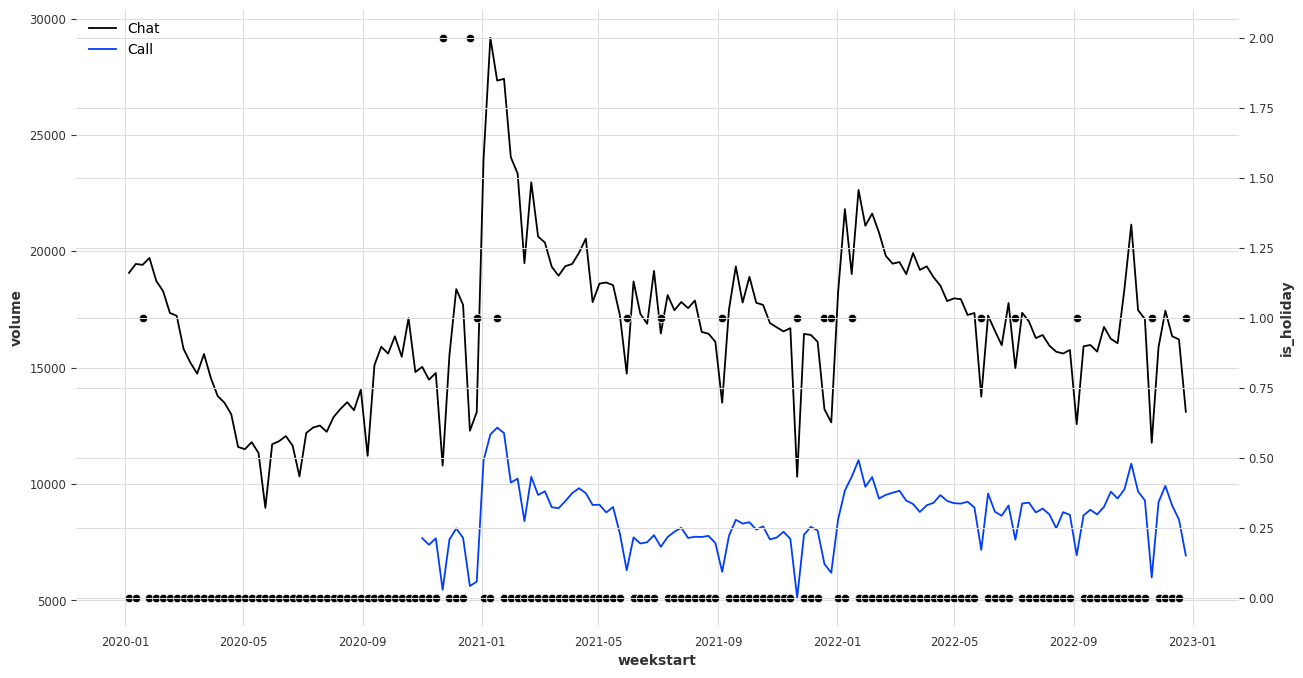

In [7]:
# plot the weekly totals to check
plt.figure(figsize=(15,8))

ax=sns.lineplot(x='weekstart'
            ,y='volume'
            ,hue='interaction_type'
            ,data=weekly_df)
sns.scatterplot(ax=ax.twinx()
            ,x='weekstart'
            ,y='is_holiday'
            ,color='black'
            ,data=weekly_df)
ax.legend(loc='upper left')

plt.show()

In [8]:
weekly_df

,weekstart,interaction_type,volume,is_holiday,is_workday
0,2020-01-05,Chat,19069,0,5
1,2020-01-12,Chat,19453,0,5
2,2020-01-19,Chat,19414,1,4
3,2020-01-26,Chat,19712,0,5
4,2020-02-02,Chat,18725,0,5
...,...,...,...,...,...
264,2022-12-11,Chat,16345,0,5
265,2022-12-18,Call,8466,0,5
266,2022-12-18,Chat,16209,0,5
267,2022-12-25,Call,6924,1,4


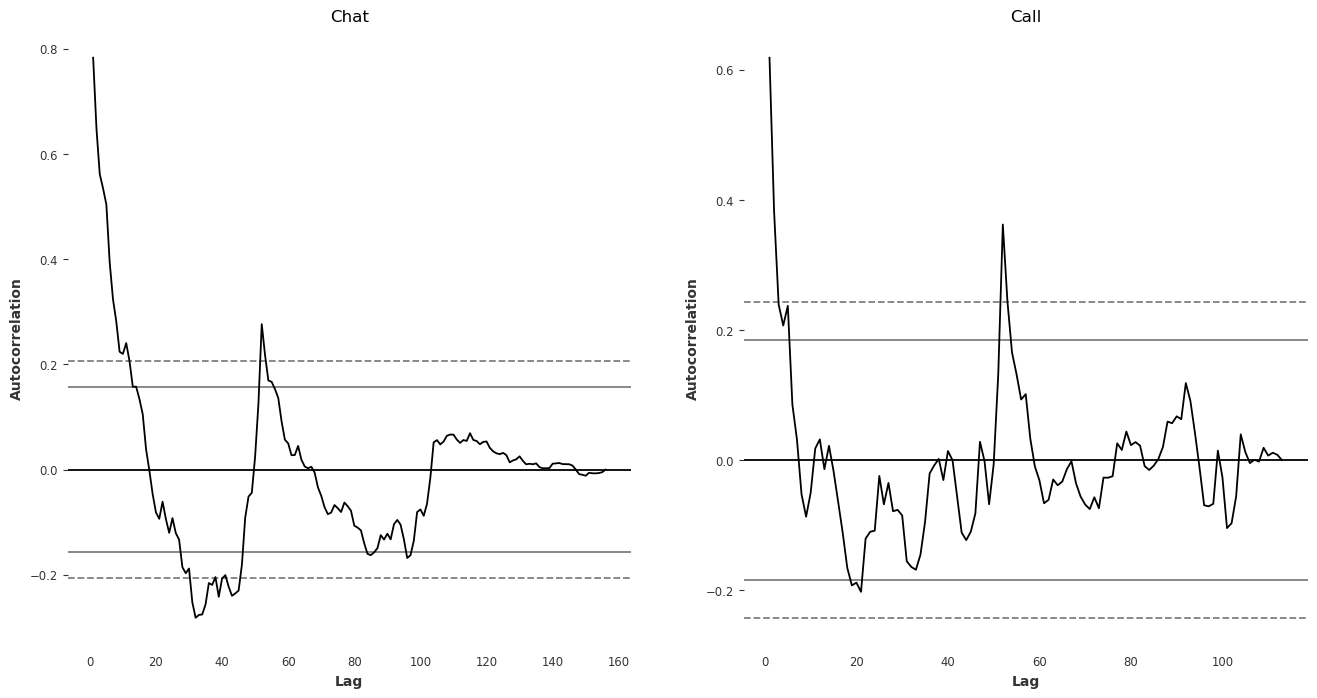

In [9]:
# plot autocorrelations
fig, ax= plt.subplots(1,2,figsize=(16,8))

pd.plotting.autocorrelation_plot(weekly_df[weekly_df['interaction_type']=='Chat']['volume'], ax=ax[0])
ax[0].set_title('Chat')

pd.plotting.autocorrelation_plot(weekly_df[weekly_df['interaction_type']=='Call']['volume'], ax=ax[1])
ax[1].set_title('Call')

plt.show()

## Below: Functions for running models and plotting results

In [10]:
##########################################################################################
# function definitions for future work--save these off
# function to easily fit and plot any model from the darts library

def fit_model(model, train, test):
    '''
    This function will fit any darts model to the training data and compare its performance to the 
    test data. train and test must be existing TimeSeries objects.
    '''
    model.fit(train)
    forecast = model.predict(len(test))
    print("model {} obtains MAPE: {:.2f}%".format(model, met.mape(test, forecast)))
    
    # if there is a get_params() method, print the parameters
    try:
        print("model parameters:",str(model.model_params))
    except:
        print('No get_params() method for this model')
        
    train.plot(label='train')
    test.plot(label='test')
    
    # trim the model name if it's really long (many params reported)
    mname = str(model)
    if len(mname) >= 43:
        mname = mname[:40]+'...'
    
    forecast.plot(label=f'Forecast ({mname})')
    return model


def run_historical_forecasts(fitted_model, actual_series, start_param = 0.7, horizon_param = 2, save = False):
    '''
    This function takes a fitted model (which can be fitted with the fit_model function above)
    and runs the historical_forecasts function against it, returning the forecast and creating
    a plot of the actuals and historical forecast results, as well as the MAPE between the two.
    '''
    # fit the historical forecast
    hist_forecast = fitted_model.historical_forecasts(actual_series, start=start_param, forecast_horizon=horizon_param)
    
    # plot the results
    actual_series.plot(label='actuals')
    
    # trim the model name if it's really long (many params reported)
    mname = str(fitted_model)
    if len(mname) >= 43:
        mname = mname[:40]+'...'
    
    hist_forecast.plot(label=mname)
    
    # title the plot with info
    plt.title(f'Historical Forecast: {mname}; Horizon: {horizon_param} wks\n')
    
    # print the MAPE result
    print("model {} \nobtains MAPE: {:.2f}%".format(mname, met.mape(actual_series, hist_forecast)))
    
    if save:
        plt.savefig(mname+'.png', bbox_inches='tight')
    
    return hist_forecast

## Production models
First, reformat the volume data to be a 2-d timeseries object for chats and calls--dropping is_holiday because we're not using it

In [11]:
# reformat the data
vol_df = weekly_df[['weekstart','interaction_type','volume']].copy()
vol_df = vol_df.pivot(columns='interaction_type', values='volume',index='weekstart')

# reset the name field of the columns because it causes darts ts conversion to fail
vol_df.columns.name=None
vol_df.head()

,Call,Chat
weekstart,,
2020-01-05,NaN,19069.0
2020-01-12,NaN,19453.0
2020-01-19,NaN,19414.0
2020-01-26,NaN,19712.0
2020-02-02,NaN,18725.0


In [12]:
# convert the volume data to a darts TimeSeries object
vol_ts = darts.TimeSeries.from_dataframe(vol_df, freq = 'W')
vol_ts

<TimeSeries (DataArray) (weekstart: 156, component: 2, sample: 1)>
array([[[   nan],
        [19069.]],

       [[   nan],
        [19453.]],

       [[   nan],
        [19414.]],

       [[   nan],
        [19712.]],

       [[   nan],
        [18725.]],

       [[   nan],
        [18285.]],

       [[   nan],
        [17347.]],
...
       [[ 9292.],
        [17083.]],

       [[ 5980.],
        [11766.]],

       [[ 9215.],
        [15877.]],

       [[ 9917.],
        [17444.]],

       [[ 9071.],
        [16345.]],

       [[ 8466.],
        [16209.]],

       [[ 6924.],
        [13101.]]])
Coordinates:
  * weekstart  (weekstart) datetime64[ns] 2020-01-05 2020-01-12 ... 2022-12-25
  * component  (component) object 'Call' 'Chat'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

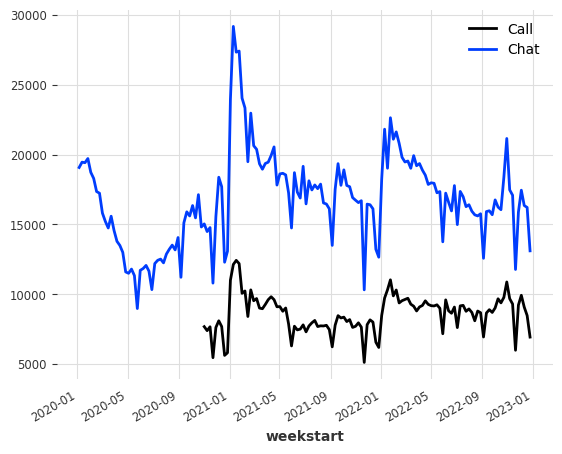

In [13]:
vol_ts.plot()

In [14]:
# create a test/train split
train, test = vol_ts.split_before(.8)


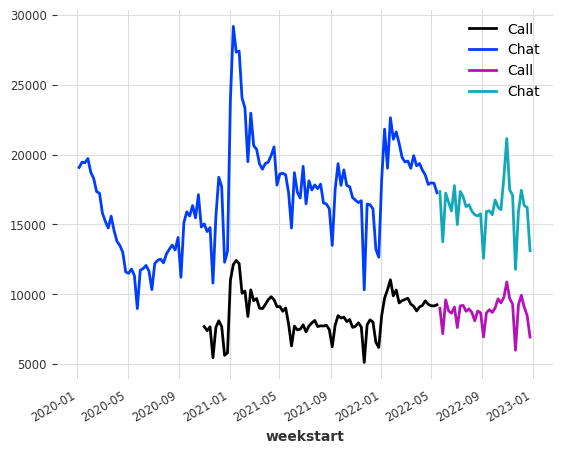

In [15]:
train.plot()
test.plot()

## run best model previously identified for chat history

C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


model SARIMA(1, 1, 1)x(1, 0, 0, 52) obtains MAPE: 6.34%
model parameters: OrderedDict([('p', 1), ('d', 1), ('q', 1), ('seasonal_order', (1, 0, 0, 52)), ('trend', None), ('random_state', 0)])


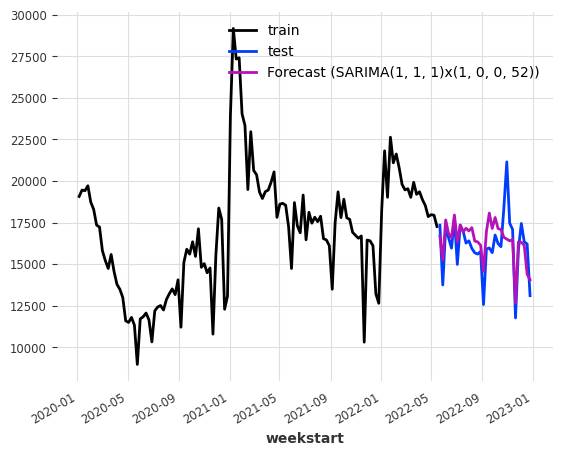

In [16]:
# the best ARIMA model for chat history found in the AutoARIMA procedure was a (1,1,1)x(1,0,0)[52]. Let's see how that looks
best_ARIMA_chat = fit_model(mod.ARIMA(p=1,d=1,q=1, seasonal_order=(1,0,0,52)), 
                           train = train['Chat'],
                           test = test['Chat'])

C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.war

model SARIMA(1, 1, 1)x(1, 0, 0, 52) 
obtains MAPE: 5.53%


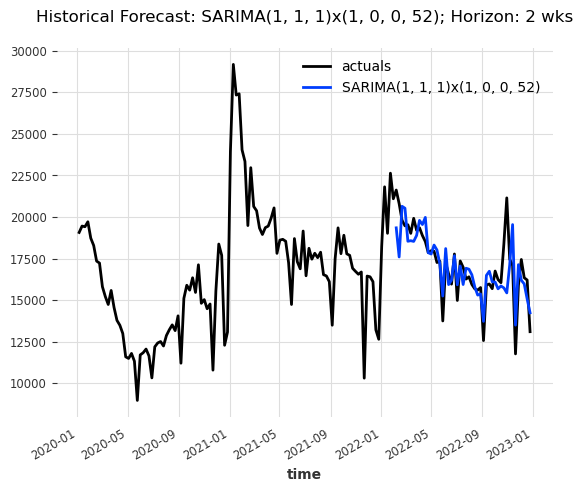

In [17]:
# run the historical forecasting test on the best ARIMA model
ARIMA_chat_hist = run_historical_forecasts(best_ARIMA_chat, vol_ts['Chat'])

## run for calls

model SARIMA(0, 1, 3)x(1, 0, 0, 52) obtains MAPE: 7.86%
model parameters: OrderedDict([('p', 0), ('d', 1), ('q', 3), ('seasonal_order', (1, 0, 0, 52)), ('trend', None), ('random_state', 0)])


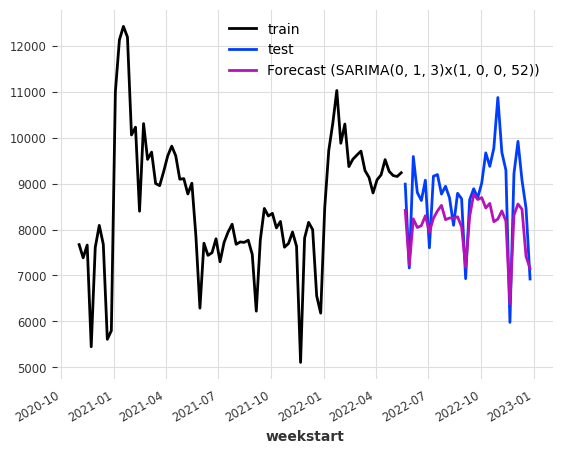

In [18]:
# best model from above: ARIMA(0,1,3)(1,0,0)[52]
# fit it on the first test/train set and run historical
best_ARIMA_call = fit_model(mod.ARIMA(p=0,d=1,q=3, seasonal_order=(1,0,0,52)),
                          train = train['Call'],
                           test = test['Call'])

model SARIMA(0, 1, 3)x(1, 0, 0, 52) 
obtains MAPE: 5.82%


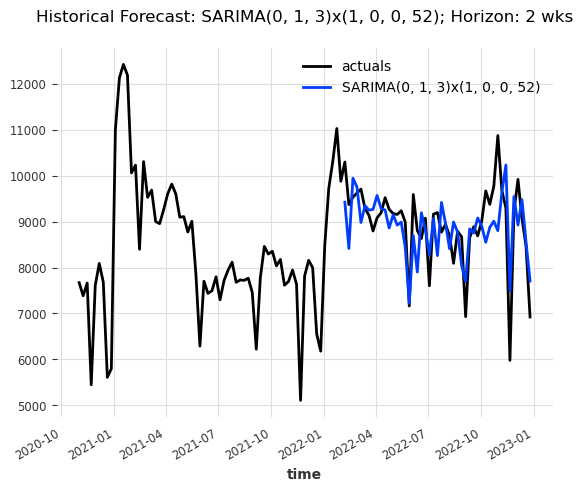

In [19]:
# run historical forecast
ARIMA_call_hist = run_historical_forecasts(best_ARIMA_call, vol_ts['Call'])

## Now run both forecasts off full data and output

In [20]:
def run_forecast(model, input_ts, forecast_horizon = 2, save=False):
    '''pass in a fitted model and the associated timeseries data, return 
        a forecast time series and optionally save the output plot'''

    fitted_model = model.fit(input_ts)
    
    # run the forecast
    forecast = fitted_model.predict(forecast_horizon)
    
    # plot input actuals
    input_ts.plot(label='actual')
    
    # trim the model name if it's really long (many params reported)
    mname = str(fitted_model)
    if len(mname) >= 43:
        mname = mname[:40]+'...'
    
    # plot the forecast
    forecast.plot(label=f'Forecast ({mname})')
    
    # save the plot if desired
    if save:
        plt.savefig(mname+'_forecast.png', bbox_inches='tight')

    
    return forecast


C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


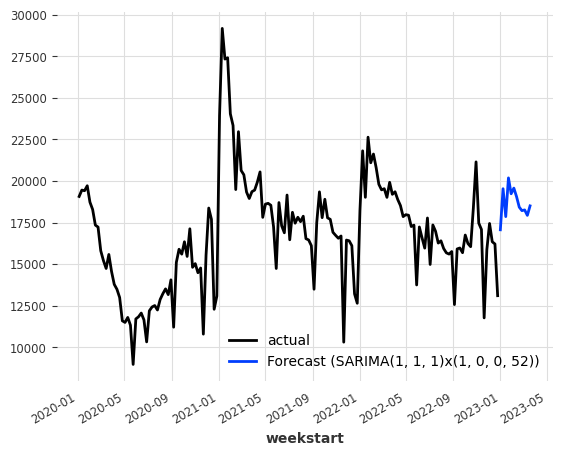

In [21]:
chat_forecast = run_forecast(best_ARIMA_chat, vol_ts['Chat'], 12)

In [22]:
chat_forecast

<TimeSeries (DataArray) (weekstart: 12, component: 1, sample: 1)>
array([[[17064.24094224]],

       [[19534.57202527]],

       [[17856.89987906]],

       [[20185.25875445]],

       [[19231.10874829]],

       [[19571.22444343]],

       [[19058.27898839]],

       [[18426.15800967]],

       [[18215.03887309]],

       [[18259.69755704]],

       [[17930.89080639]],

       [[18502.88259044]]])
Coordinates:
  * weekstart  (weekstart) datetime64[ns] 2023-01-01 2023-01-08 ... 2023-03-19
  * component  (component) object 'Chat'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

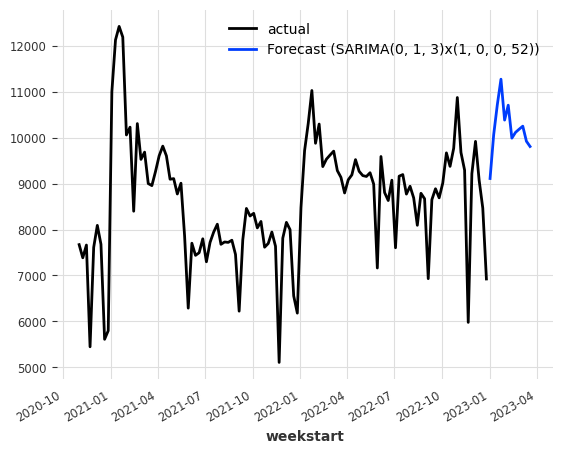

In [23]:
call_forecast = run_forecast(best_ARIMA_call, vol_ts['Call'], 12)

## output the history data to compare to existing erlang
Brie suggested we compare the call/chat historical forecasts to the erlang input model to assess performance. This section imports the erlang input and compares 

In [24]:
erlang_query = '''
    ;with 
    --------------------------------------
    -- get forecast data
    get_forecast as (
        select 
            'Forecast' as series
            ,id
            ,run_date
            ,category
            ,interaction_type
            ,day_of_week
            ,hour
            ,average
            , DATEADD(ww,DATEDIFF(ww,0,run_date),-1) as weekstart
            ,   CAST(hour as datetime) + 
                DATEADD(dd, day_of_week - 2,                  -- subtract 2 since week starts at monday (DoW 2)
                    DATEADD(ww, DATEDIFF(ww, 0, run_date), -1) -- this is the weekstart formula
                ) as bucket
        from t_wfm_erlang_inputs
        where category = 'Volume'
        )

    -- de-duplicate the forecasts by grabbing the most recent run date for each week
    , dedup_key as (
        select distinct
            weekstart
            ,max(run_date) as run_date
        from get_forecast
        group by weekstart
        )

    , get_forecast_dedup as (
        select t1.* 
        from get_forecast t1
        join dedup_key t2
        on t1.run_date = t2.run_date
        )


    select 
        series
        ,run_date as forecast_run_date
        ,weekstart
        ,cast(bucket as date) as date
        ,bucket
        ,day_of_week
        ,interaction_type
        ,average as volume
        ,t2.isHoliday as is_holiday
        ,t2.isWorkday as is_workday
        ,t2.dayname
    from get_forecast_dedup t1
    left join common.dbo.Calendar t2
    on cast(t1.bucket as date) = t2.dt
    where t1.weekstart < DATEADD(ww,DATEDIFF(ww,0,getdate()),0) -- drop data from the current (partial) week
    and t1.weekstart >= '2021-10-31'
    order by t1.bucket
    '''
erlang_input = pd.read_sql(erlang_query, engine)

In [25]:
erlang_input.head()

,series,forecast_run_date,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname
0,Forecast,2021-11-01 14:19:34.997,2021-10-31,2021-10-31,2021-10-31 08:00:00,2,Call,14.7,False,False,Sunday
1,Forecast,2021-11-01 14:19:34.997,2021-10-31,2021-10-31,2021-10-31 08:00:00,2,Chat,31.0,False,False,Sunday
2,Forecast,2021-11-01 14:19:34.997,2021-10-31,2021-10-31,2021-10-31 08:30:00,2,Chat,61.0,False,False,Sunday
3,Forecast,2021-11-01 14:19:34.997,2021-10-31,2021-10-31,2021-10-31 08:30:00,2,Call,30.3,False,False,Sunday
4,Forecast,2021-11-01 14:19:34.997,2021-10-31,2021-10-31,2021-10-31 09:00:00,2,Call,54.4,False,False,Sunday


In [26]:
# prep data to pass to darts
erl_wk = erlang_input[['weekstart','interaction_type','volume']].groupby(['weekstart','interaction_type'],as_index=False).sum()
erl_wk['weekstart'] = pd.to_datetime(erl_wk['weekstart'])

# get a series key for chats/calls
chat_key = erl_wk['interaction_type']=='Chat'
call_key = erl_wk['interaction_type']=='Call'

In [27]:
chat_erl_ts = darts.TimeSeries.from_dataframe(erl_wk[chat_key].drop(columns='interaction_type').set_index('weekstart'), freq = 'W')
call_erl_ts = darts.TimeSeries.from_dataframe(erl_wk[call_key].drop(columns='interaction_type').set_index('weekstart'), freq = 'W')

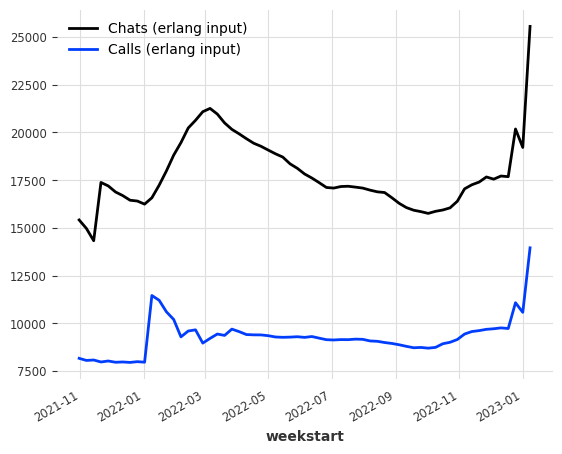

In [28]:
# plot to compare
chat_erl_ts.plot(label='Chats (erlang input)')
call_erl_ts.plot(label='Calls (erlang input)')

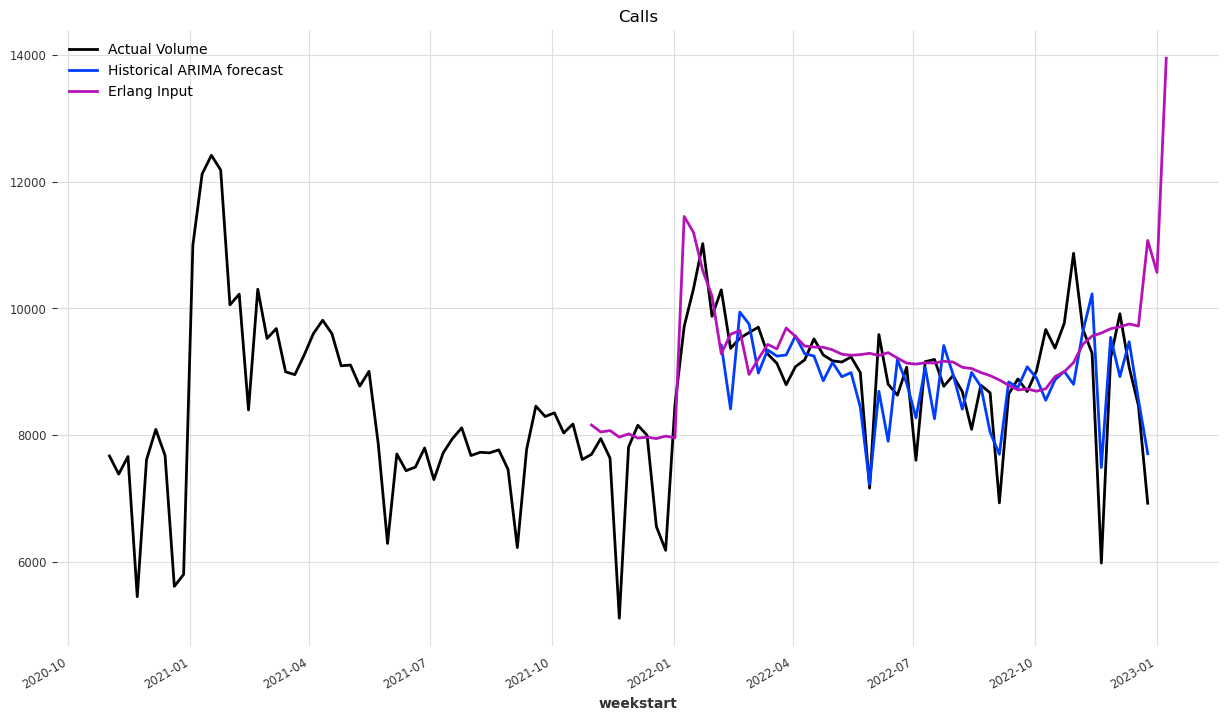

In [29]:
# plot calls
plt.figure(figsize=(15,8))
vol_ts['Call'].plot(label='Actual Volume')
ARIMA_call_hist.plot(label='Historical ARIMA forecast')
call_erl_ts.plot(label='Erlang Input')

plt.title('Calls')
plt.show()

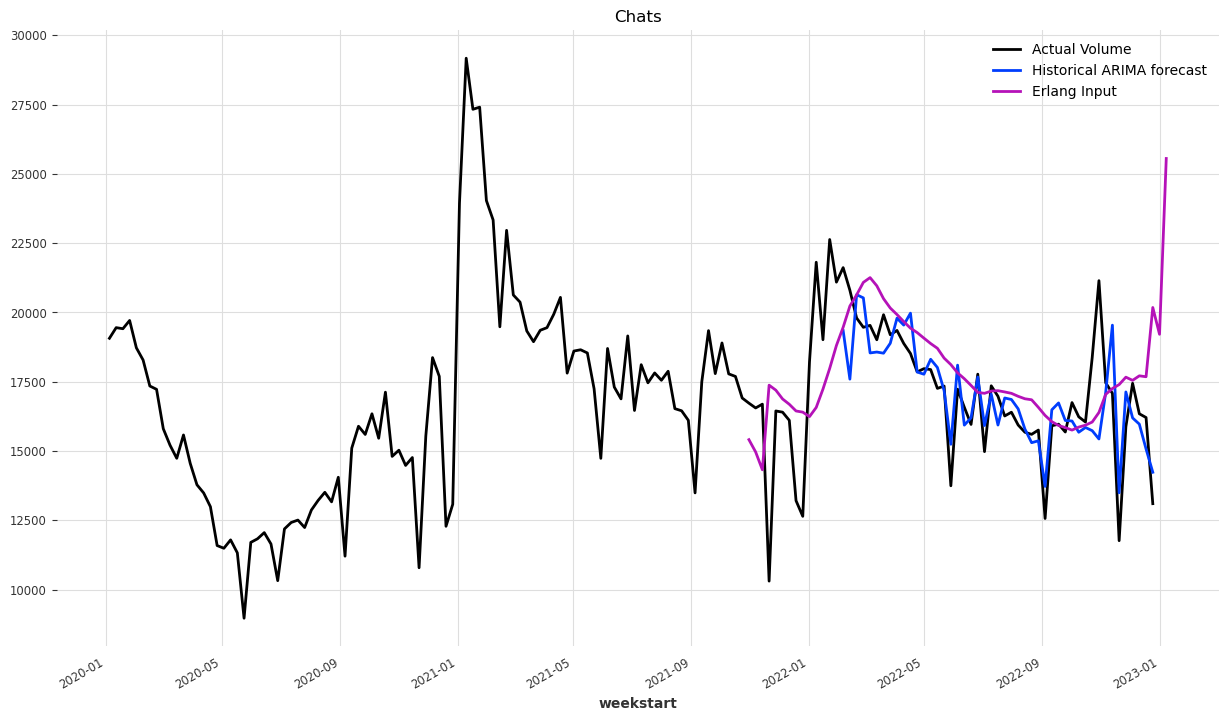

In [30]:
# plot chats
plt.figure(figsize=(15,8))
vol_ts['Chat'].plot(label='Actual Volume')
ARIMA_chat_hist.plot(label='Historical ARIMA forecast')
chat_erl_ts.plot(label='Erlang Input')

plt.title('Chats')
plt.show()

# combine and output the forecast data

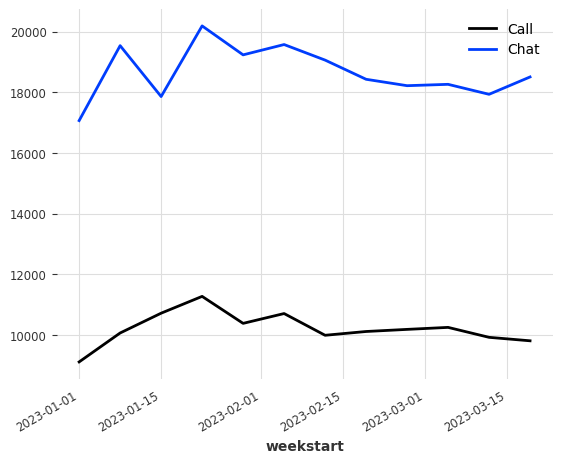

In [31]:
# combine the forecasts into one timeseries
forecast_combine = call_forecast.stack(chat_forecast)
#forecast_combine = forecast_combine.with_columns_renamed(['Call','Chat'],['Call Forecast','Chat Forecast'])
forecast_combine.plot()

In [32]:
# convert the data to a dataframe and add an indicator column
for_df = forecast_combine.pd_dataframe()
for_df['source'] = 'Forecast'

# add the same indicator to the actuals
vol_df['source'] = 'Actual'

out_df = pd.concat((vol_df,for_df))
out_df

,Call,Chat,source
weekstart,,,
2020-01-05,NaN,19069.000000,Actual
2020-01-12,NaN,19453.000000,Actual
2020-01-19,NaN,19414.000000,Actual
2020-01-26,NaN,19712.000000,Actual
2020-02-02,NaN,18725.000000,Actual
...,...,...,...
2023-02-19,10112.443594,18426.158010,Forecast
2023-02-26,10182.164597,18215.038873,Forecast
2023-03-05,10248.012212,18259.697557,Forecast


In [33]:
# rearrange our data to make the output a little nicer
calls=out_df[['Call','source']].rename(columns={'Call':'volume'}).reset_index()
calls.insert(1,'type','Call') 


chats=out_df[['Chat','source']].rename(columns={'Chat':'volume'}).reset_index()
chats.insert(1,'type','Chat') 

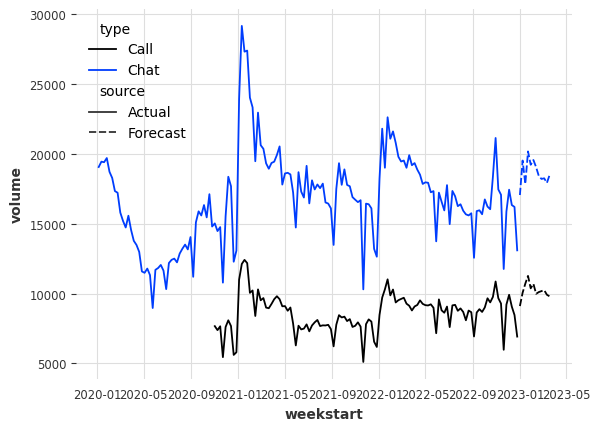

In [34]:
# plot our output df just to be sure

forecast_df = pd.concat((calls,chats)).reset_index(drop=True)

sns.lineplot(x= 'weekstart'
            ,y= 'volume'
            ,hue='type'
            ,style='source'
            ,data = forecast_df)


plt.show()

# pull in averages by time block
Code here mostly copied from NAT-818 v3 notebook


In [35]:
# get the last 8 weeks for averaging
tgt_date = raw_df['weekstart'].max() - pd.Timedelta(8,'W')

block_df = raw_df[raw_df['weekstart'] >= tgt_date].copy().reset_index(drop=True)

# add in an 'hour' column for use when averaging later
block_df['hour'] = block_df['bucket'].dt.strftime('%H:%M')


block_df

,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname,hour
0,2022-10-30,2022-10-31,2022-10-31 08:00:00,2,Call,29,False,True,Monday,08:00
1,2022-10-30,2022-10-31,2022-10-31 08:00:00,2,Chat,49,False,True,Monday,08:00
2,2022-10-30,2022-10-31,2022-10-31 08:30:00,2,Chat,122,False,True,Monday,08:30
3,2022-10-30,2022-10-31,2022-10-31 08:30:00,2,Call,53,False,True,Monday,08:30
4,2022-10-30,2022-10-31,2022-10-31 09:00:00,2,Call,69,False,True,Monday,09:00
...,...,...,...,...,...,...,...,...,...,...
2855,2022-12-25,2022-12-31,2022-12-31 15:00:00,7,Chat,7,False,False,Saturday,15:00
2856,2022-12-25,2022-12-31,2022-12-31 15:30:00,7,Call,4,False,False,Saturday,15:30
2857,2022-12-25,2022-12-31,2022-12-31 15:30:00,7,Chat,3,False,False,Saturday,15:30
2858,2022-12-25,2022-12-31,2022-12-31 16:00:00,7,Call,2,False,False,Saturday,16:00


In [36]:
# ignore holidays as they may skew the percentages
block_df = block_df[~ block_df['is_holiday']]

In [37]:
# adjust the volume to account for holiday weeks
adj_vol_df = vol_df.merge(day_counts, left_index=True, right_index=True)

# for weeks with 4 workdays, multiply volumes by a factor of 5/4
adj_vol_df['Call'] = adj_vol_df['Call'] * (5 / (5 - (adj_vol_df['is_workday'] < 5)))
adj_vol_df['Chat'] = adj_vol_df['Chat'] * (5 / (5 - (adj_vol_df['is_workday'] < 5)))

# adj_vol_df

In [38]:
# join in the weekly totals from the input data
block_df = block_df.merge(adj_vol_df[['Call', 'Chat']], how ='left', left_on = 'weekstart', right_index=True)

In [39]:
# define a function to calculate the percentage volume conditional on interaction_type
def map_func(row):
    if row['interaction_type'] == 'Call':
        return row['volume'] / row['Call']
    elif row['interaction_type'] == 'Chat':
        return row['volume'] / row['Chat']
    else:
        return np.nan

In [40]:
block_df

,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname,hour,Call,Chat
0,2022-10-30,2022-10-31,2022-10-31 08:00:00,2,Call,29,False,True,Monday,08:00,10871.0,21148.00
1,2022-10-30,2022-10-31,2022-10-31 08:00:00,2,Chat,49,False,True,Monday,08:00,10871.0,21148.00
2,2022-10-30,2022-10-31,2022-10-31 08:30:00,2,Chat,122,False,True,Monday,08:30,10871.0,21148.00
3,2022-10-30,2022-10-31,2022-10-31 08:30:00,2,Call,53,False,True,Monday,08:30,10871.0,21148.00
4,2022-10-30,2022-10-31,2022-10-31 09:00:00,2,Call,69,False,True,Monday,09:00,10871.0,21148.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2855,2022-12-25,2022-12-31,2022-12-31 15:00:00,7,Chat,7,False,False,Saturday,15:00,8655.0,16376.25
2856,2022-12-25,2022-12-31,2022-12-31 15:30:00,7,Call,4,False,False,Saturday,15:30,8655.0,16376.25
2857,2022-12-25,2022-12-31,2022-12-31 15:30:00,7,Chat,3,False,False,Saturday,15:30,8655.0,16376.25
2858,2022-12-25,2022-12-31,2022-12-31 16:00:00,7,Call,2,False,False,Saturday,16:00,8655.0,16376.25


In [41]:
# use the df.apply method to apply the function created above and calculate percent of weekly volume for each time period
block_df['volume_pct'] = block_df.apply(map_func, axis=1)
block_df.head()

,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname,hour,Call,Chat,volume_pct
0,2022-10-30,2022-10-31,2022-10-31 08:00:00,2,Call,29,False,True,Monday,08:00,10871.0,21148.0,0.002668
1,2022-10-30,2022-10-31,2022-10-31 08:00:00,2,Chat,49,False,True,Monday,08:00,10871.0,21148.0,0.002317
2,2022-10-30,2022-10-31,2022-10-31 08:30:00,2,Chat,122,False,True,Monday,08:30,10871.0,21148.0,0.005769
3,2022-10-30,2022-10-31,2022-10-31 08:30:00,2,Call,53,False,True,Monday,08:30,10871.0,21148.0,0.004875
4,2022-10-30,2022-10-31,2022-10-31 09:00:00,2,Call,69,False,True,Monday,09:00,10871.0,21148.0,0.006347


In [42]:
# drop the total weekly volume columns since they're no longer needed
# block_df.drop(columns=('Call','Chat'),inplace=True)

In [43]:
# block_df.to_excel('testdata_8wkavg.xlsx')

In [44]:
# calculate averages for each day/time period
group_cols = ['dayname','day_of_week','hour','interaction_type']

weekly_avgs = block_df[group_cols + ['volume_pct']].groupby(group_cols, as_index=False).mean()
weekly_avgs

,dayname,day_of_week,hour,interaction_type,volume_pct
0,Friday,6,08:00,Call,0.002823
1,Friday,6,08:00,Chat,0.002508
2,Friday,6,08:30,Call,0.004698
3,Friday,6,08:30,Chat,0.004843
4,Friday,6,09:00,Call,0.006942
...,...,...,...,...,...
335,Wednesday,4,21:30,Chat,0.000232
336,Wednesday,4,22:00,Call,0.000236
337,Wednesday,4,22:00,Chat,0.000163
338,Wednesday,4,22:30,Call,0.000122


In [45]:
# check that we average ~100% total for the week
interaction_totals = weekly_avgs.groupby('interaction_type').sum(numeric_only=True)
interaction_totals

,day_of_week,volume_pct
interaction_type,,
Call,740,1.002281
Chat,740,1.005616


In [46]:
# adjust the percentages so that the averages all total to 100
weekly_avgs = weekly_avgs.merge(interaction_totals['volume_pct'].rename('adj factor'), left_on ='interaction_type', right_index=True)

weekly_avgs['adj_vol_pct'] = weekly_avgs['volume_pct'] / weekly_avgs['adj factor']

weekly_avgs.drop(columns='adj factor', inplace=True)

# check that the adjusted number now adds up to 1
weekly_avgs.groupby('interaction_type').sum(numeric_only=True)

,day_of_week,volume_pct,adj_vol_pct
interaction_type,,,
Call,740,1.002281,1.0
Chat,740,1.005616,1.0


In [47]:
weekly_avgs

,dayname,day_of_week,hour,interaction_type,volume_pct,adj_vol_pct
0,Friday,6,08:00,Call,0.002823,0.002817
2,Friday,6,08:30,Call,0.004698,0.004687
4,Friday,6,09:00,Call,0.006942,0.006926
6,Friday,6,09:30,Call,0.007889,0.007871
8,Friday,6,10:00,Call,0.008651,0.008632
...,...,...,...,...,...,...
331,Wednesday,4,20:30,Chat,0.000613,0.000610
333,Wednesday,4,21:00,Chat,0.000344,0.000342
335,Wednesday,4,21:30,Chat,0.000232,0.000230
337,Wednesday,4,22:00,Chat,0.000163,0.000162


## Final part: combine the forecast output with the percentages to break into half-hours

In [48]:
# test set that should match what we'll be working with in production form
forecast_df_test = forecast_df[forecast_df['source']=='Forecast'].sort_values(['weekstart','type']).head(4)
forecast_df_test

,weekstart,type,volume,source
156,2023-01-01,Call,9109.847705,Forecast
324,2023-01-01,Chat,17064.240942,Forecast
157,2023-01-08,Call,10063.234874,Forecast
325,2023-01-08,Chat,19534.572025,Forecast


In [49]:
# merge the forecast with each day/time factor
keep_cols=['dayname', 'day_of_week', 'hour', 'interaction_type', 'adj_vol_pct']
final_df = forecast_df_test.merge(weekly_avgs[keep_cols], how='left', left_on='type', right_on='interaction_type')

In [50]:
# apply the percentages
final_df['volume'] = final_df['volume'] * final_df['adj_vol_pct']
final_df.drop(columns=['interaction_type','adj_vol_pct'], inplace=True)
final_df

,weekstart,type,volume,source,dayname,day_of_week,hour
0,2023-01-01,Call,25.660431,Forecast,Friday,6,08:00
1,2023-01-01,Call,42.699880,Forecast,Friday,6,08:30
2,2023-01-01,Call,63.098561,Forecast,Friday,6,09:00
3,2023-01-01,Call,71.707128,Forecast,Friday,6,09:30
4,2023-01-01,Call,78.632250,Forecast,Friday,6,10:00
...,...,...,...,...,...,...,...
675,2023-01-08,Chat,11.910073,Forecast,Wednesday,4,20:30
676,2023-01-08,Chat,6.679433,Forecast,Wednesday,4,21:00
677,2023-01-08,Chat,4.499428,Forecast,Wednesday,4,21:30
678,2023-01-08,Chat,3.159256,Forecast,Wednesday,4,22:00


In [51]:
# add a date field
final_df['date'] = final_df['weekstart'] + pd.to_timedelta(final_df['day_of_week'] - 1, unit='days')
final_df

,weekstart,type,volume,source,dayname,day_of_week,hour,date
0,2023-01-01,Call,25.660431,Forecast,Friday,6,08:00,2023-01-06
1,2023-01-01,Call,42.699880,Forecast,Friday,6,08:30,2023-01-06
2,2023-01-01,Call,63.098561,Forecast,Friday,6,09:00,2023-01-06
3,2023-01-01,Call,71.707128,Forecast,Friday,6,09:30,2023-01-06
4,2023-01-01,Call,78.632250,Forecast,Friday,6,10:00,2023-01-06
...,...,...,...,...,...,...,...,...
675,2023-01-08,Chat,11.910073,Forecast,Wednesday,4,20:30,2023-01-11
676,2023-01-08,Chat,6.679433,Forecast,Wednesday,4,21:00,2023-01-11
677,2023-01-08,Chat,4.499428,Forecast,Wednesday,4,21:30,2023-01-11
678,2023-01-08,Chat,3.159256,Forecast,Wednesday,4,22:00,2023-01-11


In [52]:
final_df['time_block']=pd.to_datetime(final_df['date'].astype(str)+' '+final_df['hour'])

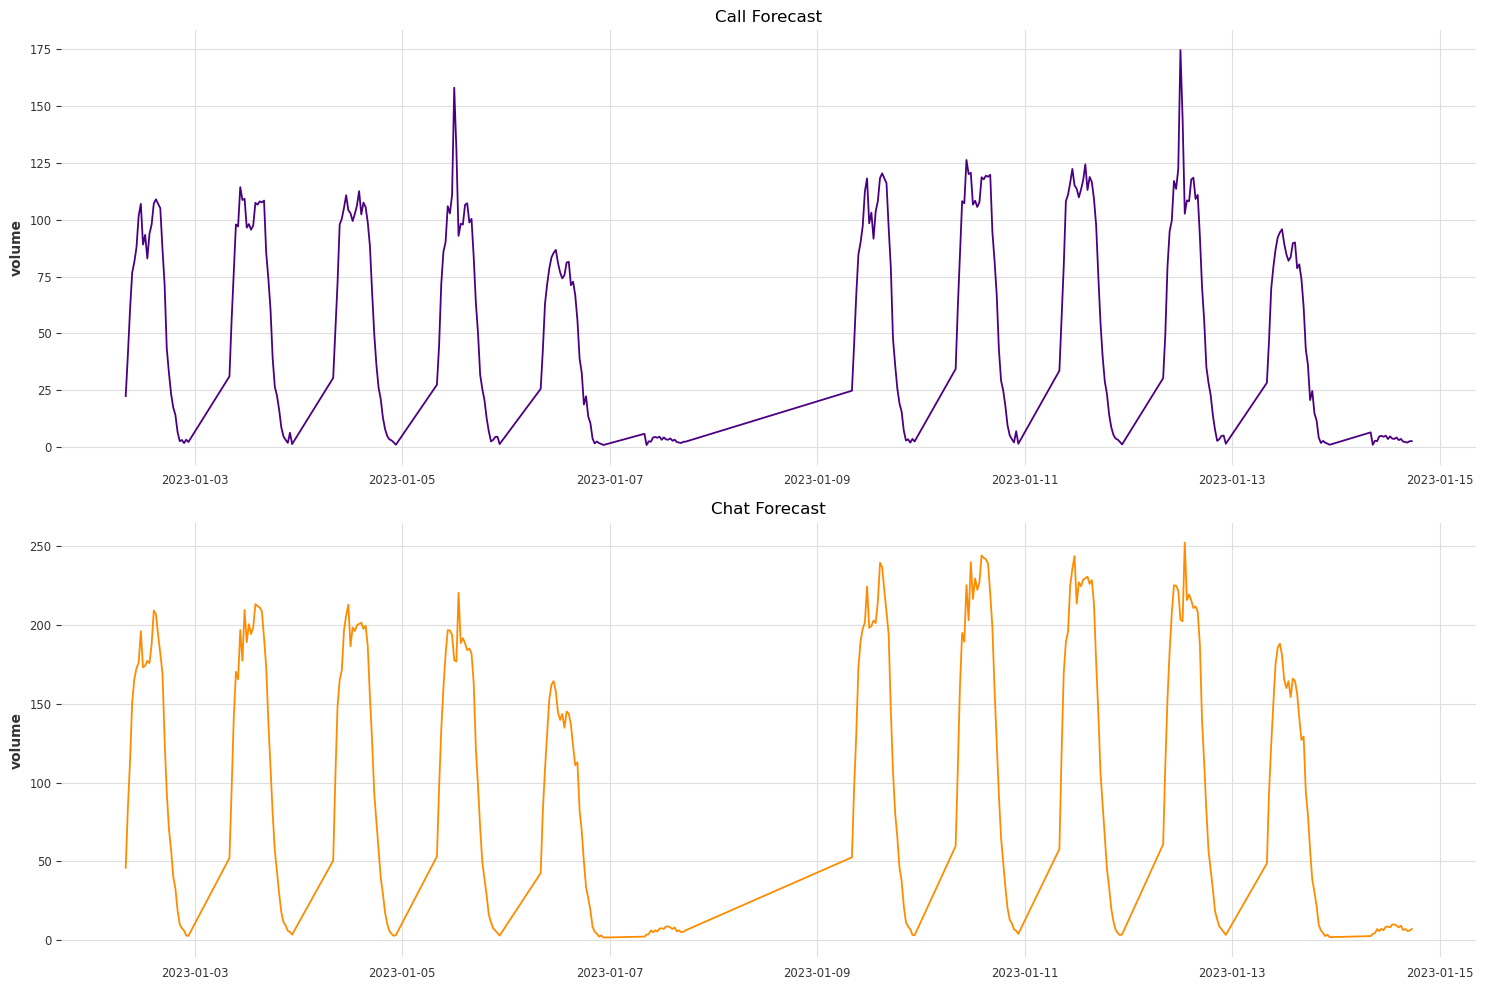

In [53]:
# plot the results

fig,ax = plt.subplots(2,1, figsize=(15,10))

sns.lineplot(ax = ax[0]
            ,x='time_block'
            ,y='volume'
            ,color='indigo'
            ,data=final_df[final_df['type']=='Call'])
ax[0].set_title('Call Forecast')
ax[0].set_xlabel(None)

sns.lineplot(ax = ax[1]
            ,x='time_block'
            ,y='volume'
            ,color='darkorange'
            ,data=final_df[final_df['type']=='Chat'])
ax[1].set_title('Chat Forecast')
ax[1].set_xlabel(None)

fig.tight_layout()

plt.show()

**The above plot shows that the hourly percentage forecast methodology appears to work.** One point to note is that there is a significant spike in call volume for the Thursday 12:00 PM time block in both forecast weeks. This is due to a system outage which occured in the 12:00 PM Thursday block in early December, which caused an extraordinarily high volume of calls, skewing the overall average. This demonstrates the need for some robustness to outliers in the calculation of rolling average distribution. The next section will attempt to build this.

## Removing extreme outliers from rolling averages

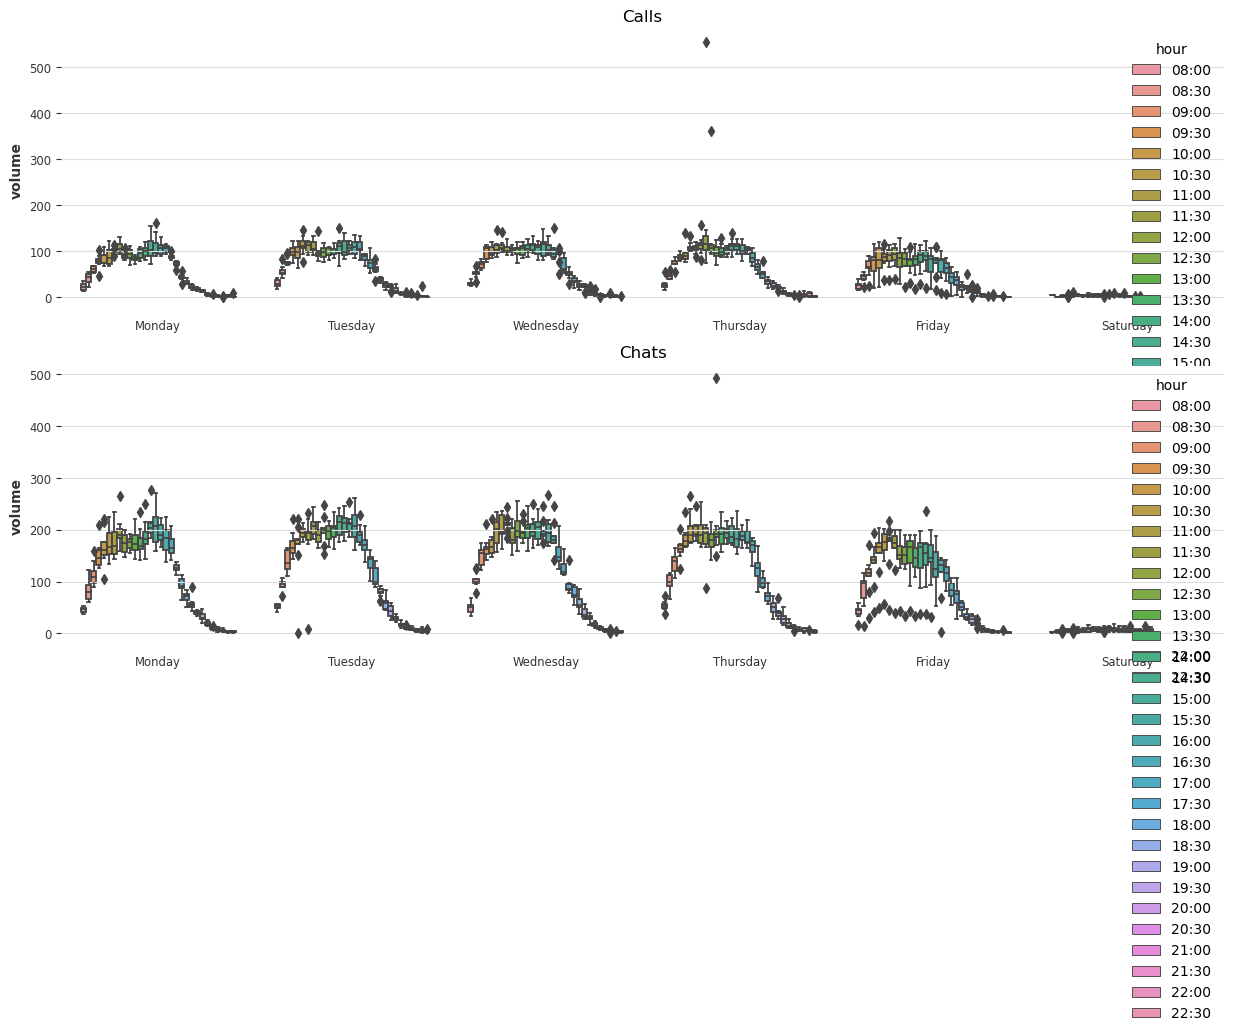

In [54]:
# from NAT-813: plotting hourly distributions
# --------------------------------------------------
# plot actuals hourly distributions
fig, ax = plt.subplots(2,1, figsize=(15,8))


sns.boxplot(ax=ax[0],
            x='dayname', 
            y='volume', 
            hue='hour', 
            data=block_df[(block_df['interaction_type']=='Call')].sort_values(['hour','day_of_week'])
            ,showfliers=True
            #,order = dayorder
           )
#plt.legend(title='hour', bbox_to_anchor=(1.04, 1), loc="upper left")
ax[0].set_title('Calls')
ax[0].set_xlabel(None)

sns.boxplot(ax=ax[1],
            x='dayname', 
            y='volume', 
            hue='hour', 
            data=block_df[(block_df['interaction_type']=='Chat')].sort_values(['hour','day_of_week'])
            ,showfliers=True
            #,order = dayorder
           )
# plt.legend(title='hour', bbox_to_anchor=(1.04, 1), loc="upper left")
ax[1].set_title('Chats')
ax[1].set_xlabel(None)

plt.show()

In [55]:
block_df.sort_values('volume',ascending=False).head(20)

,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname,hour,Call,Chat,volume_pct
1783,2022-12-04,2022-12-08,2022-12-08 12:00:00,5,Call,553,False,True,Thursday,12:00,9917.0,17444.0,0.055763
1787,2022-12-04,2022-12-08,2022-12-08 13:00:00,5,Chat,492,False,True,Thursday,13:00,9917.0,17444.0,0.028205
1784,2022-12-04,2022-12-08,2022-12-08 12:30:00,5,Call,360,False,True,Thursday,12:30,9917.0,17444.0,0.036301
27,2022-10-30,2022-10-31,2022-10-31 14:30:00,2,Chat,276,False,True,Monday,14:30,10871.0,21148.0,0.013051
29,2022-10-30,2022-10-31,2022-10-31 15:00:00,2,Chat,271,False,True,Monday,15:00,10871.0,21148.0,0.012814
147,2022-10-30,2022-11-02,2022-11-02 15:30:00,4,Chat,267,False,True,Wednesday,15:30,10871.0,21148.0,0.012625
187,2022-10-30,2022-11-03,2022-11-03 10:30:00,5,Chat,265,False,True,Thursday,10:30,10871.0,21148.0,0.012531
15,2022-10-30,2022-10-31,2022-10-31 11:30:00,2,Chat,265,False,True,Monday,11:30,10871.0,21148.0,0.012531
89,2022-10-30,2022-11-01,2022-11-01 15:30:00,3,Chat,262,False,True,Tuesday,15:30,10871.0,21148.0,0.012389
361,2022-11-06,2022-11-07,2022-11-07 15:00:00,2,Chat,260,False,True,Monday,15:00,9676.0,17466.0,0.014886


### First looking at Z scores

In [56]:
from scipy import stats

In [57]:
stats.zscore(block_df['volume']).sort_values(ascending=False)

1783    6.757182
1787    5.886031
1784    4.000916
27      2.801297
29      2.729891
          ...   
2555   -1.126025
443    -1.126025
2552   -1.126025
439    -1.126025
1764   -1.126025
Name: volume, Length: 2827, dtype: float64

In [58]:
block_df.groupby(['interaction_type','dayname','hour'])['volume'].transform(lambda x : stats.zscore(x, ddof=1)).sort_values(ascending = False)

C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\nathaniel.kramer\.conda\envs\timeseries_env\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1885    2.558651
155     2.496547
1784    2.464798
149     2.451452
1783    2.450790
          ...   
1222         NaN
1549         NaN
1552         NaN
1553         NaN
1882         NaN
Name: volume, Length: 2827, dtype: float64

In [59]:
block_df['grouped z score'] = block_df.groupby(['interaction_type','dayname','hour'])['volume'].transform(lambda x : stats.zscore(x))

In [193]:
# function for picking/plotting z score thresholds (Subplot version of the plot below)
def plot_z_thresh_subplots(z_threshold, dat = block_df, save =False):
    
    # process the data as a df
    t_df = dat.sort_values(['day_of_week','hour'])

    # create plotting vars
    t_df['x_var'] = t_df['dayname'].str[:3]+'\n'+t_df['hour']
    t_df['Exceeds Z-score Threshold'] = abs(t_df['grouped z score']) > z_threshold
   
    # plot the data
    fig,ax = plt.subplots(2,1, figsize=(12,12))

    #set color palette
    color_pal=['b','r']

    sns.scatterplot(ax=ax[0]
                    ,x='x_var'
                   ,y='volume'
                   ,hue='Exceeds Z-score Threshold'
                   ,style='Exceeds Z-score Threshold'
                   ,data=t_df[t_df['interaction_type']=='Call']
                    ,palette=color_pal
                    )
    ax[0].set_title(f'Calls  |  Z-score Threshold: {z_threshold}')
        
    sns.scatterplot(ax=ax[1]
                    ,x='x_var'
                   ,y='volume'
                   ,hue='Exceeds Z-score Threshold'
                   ,style='Exceeds Z-score Threshold'
                   ,data=t_df[t_df['interaction_type']=='Chat']
                    ,palette=color_pal
                    )
    ax[1].set_title(f'Chats  |  Z-score Threshold: {z_threshold}')
        
    
    # adjust x axis ticks
    skip = 14 # number of steps to skip in the axis ticks
    
    for axis in ax:
        # get tick params
        x_locs, x_labels = axis.get_xticks(), axis.get_xticklabels()
        
        #set tick params
        axis.set_xticks(x_locs[::skip])
        axis.set_xticklabels(x_labels[::skip])
        
        # clear the xlabel
        axis.set_xlabel(None)
    
    if save:
        plt.savefig(f'z_score_thresh ({z_threshold}, subplots).png', bbox_inches='tight')
        
    plt.show()
    return None

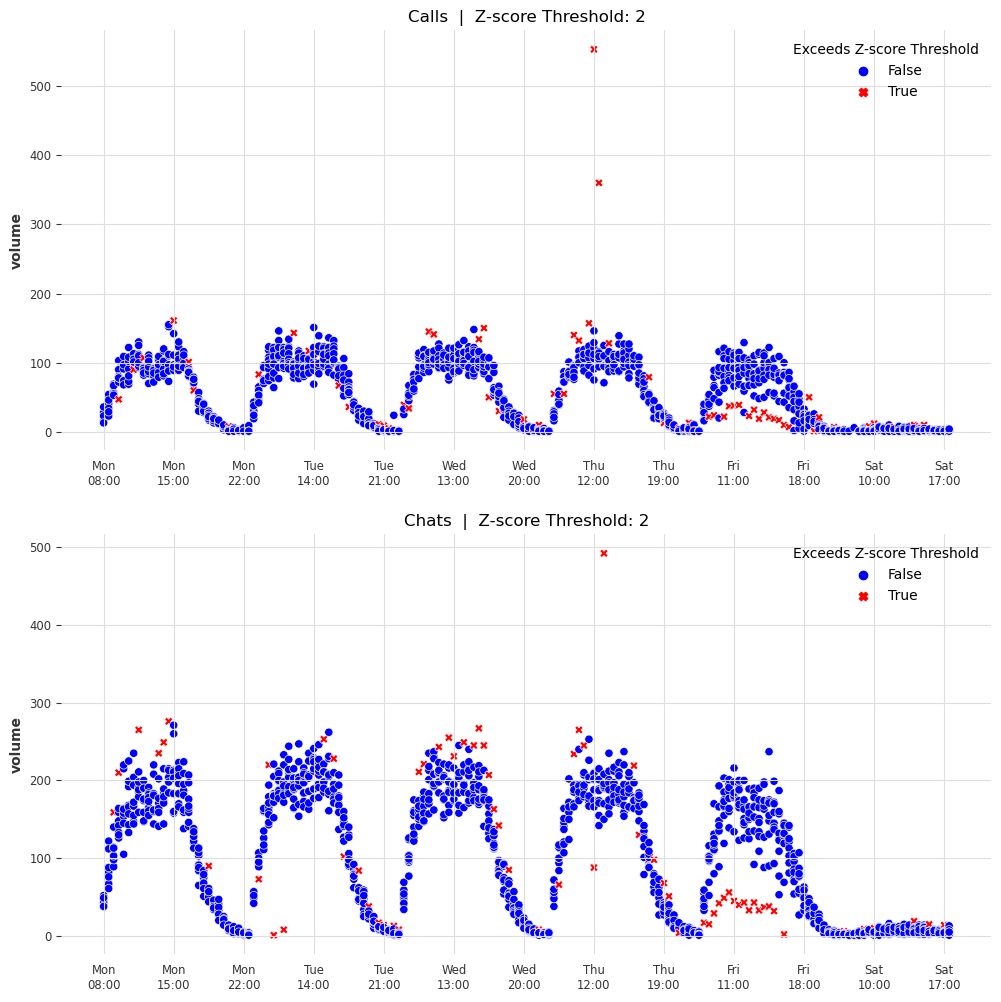

In [194]:
plot_z_thresh_subplots(2, save=True)

In [139]:
# function for picking/plotting z score thresholds
def plot_z_thresh(z_threshold, include='Both', dat = block_df, abs_thresh = True, save=False):
    '''
    Pick a threshold z score and see whether data points would have been in or out. "include" can be, "Call",
    "Chat", or "Both" and plots will be grouped by hue/marker accordingly.
    abs_thresh determines whether the absolute value will be used for calculating the threshold performance (i.e. whether
        we want to hold out high AND low values [True], or just high values [False])
    '''
    # process the data as a df
    if include =='Both':
        t_df = dat.sort_values(['day_of_week','hour'])
    else:
        try:
            t_df = dat[dat['interaction_type']==include].copy().sort_values(['day_of_week','hour'])
        except:
            raise ValueError('include must be "Call", "Chat", or "Both"')
    
    # create plotting vars
    t_df['x_var'] = t_df['dayname'].str[:3]+'\n'+t_df['hour']
    
    if abs_thresh:
        t_df['Exceeds Z-score Threshold'] = abs(t_df['grouped z score']) > z_threshold
    else:
        t_df['Exceeds Z-score Threshold'] = t_df['grouped z score'] > z_threshold
    
    # plot the data
    plt.figure(figsize=(12,8))

    # if both, use hue and marker style
    if include =='Both':
        sns.scatterplot(x='x_var'
                   ,y='volume'
                   ,hue='interaction_type'
                   ,style='Exceeds Z-score Threshold'
                   ,data=t_df
                    )
        
    # otherwise, only use hue
    else:
        
        sns.scatterplot(x='x_var'
                   ,y='volume'
                   ,hue='Exceeds Z-score Threshold'
                   ,style='Exceeds Z-score Threshold'
                   ,data=t_df
                    ,palette=['b','r'])
        
    plt.title(f'Volume: {include}  |  Z-score Threshold: {z_threshold}  |  Absolute Z: {abs_thresh}')
    
    # adjust x axis ticks
    skip = 14 # number of steps to skip in the axis ticks
    x_locs, x_labels = plt.xticks()
#     plt.xticks(plt.xticks()[0][::12], plt.xticks()[1][::15], rotation=0)
    plt.xticks(x_locs[::skip], x_labels[::skip], rotation=0)
    
    
    plt.xlabel(None)
    
    if save:
        plt.savefig(f'z_score_thresh ({z_threshold}, {include}).png', bbox_inches='tight')
        
    plt.show()
    return None

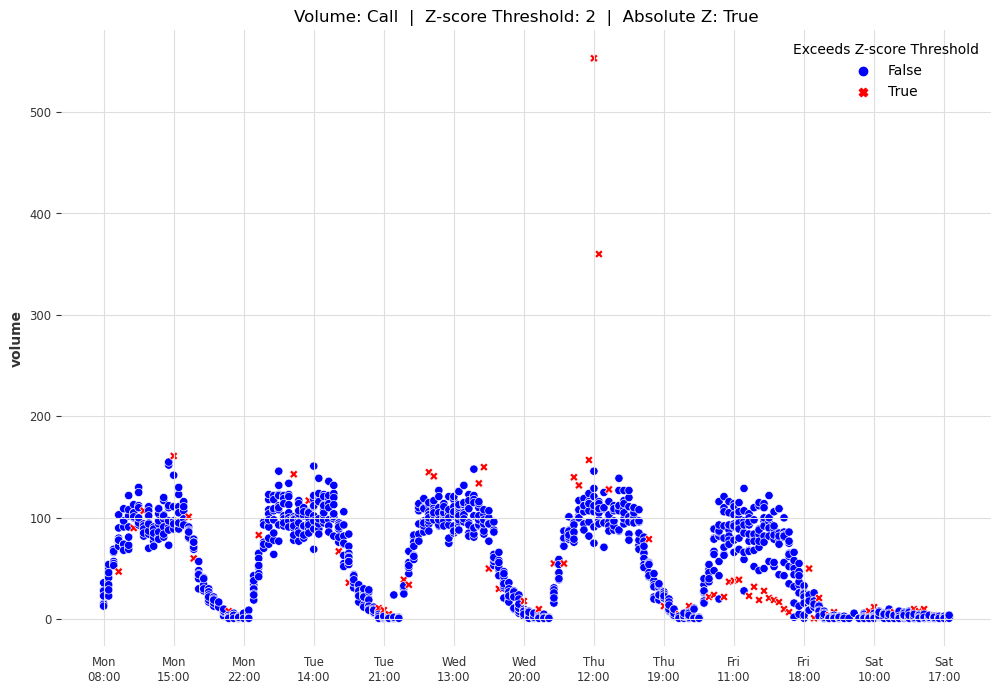

In [190]:
plot_z_thresh(2, 'Call', abs_thresh=True, save=True)

#### crazy idea: plot the same plot as above with z scores mapped to hue

In [180]:
# function for picking/plotting z score thresholds
def plot_z_scatter(dat = block_df, save =False):
    '''
    Scatter plot of volume by day/time with z score as hue param
    '''
    # process the data as a df
    t_df = dat.sort_values(['day_of_week','hour'])

    # create plotting vars
    t_df['x_var'] = t_df['dayname'].str[:3]+'\n'+t_df['hour']
    
   
    # plot the data
    fig,ax = plt.subplots(2,1, figsize=(12,12))

    #set color palette
    color_pal = 'Spectral'

    sns.scatterplot(ax=ax[0]
                    ,x='x_var'
                   ,y='volume'
                   ,hue='grouped z score'
                   ,data=t_df[t_df['interaction_type']=='Call']
                    ,palette=color_pal
                    )
    ax[0].set_title('Calls')
        
    sns.scatterplot(ax=ax[1]
                    ,x='x_var'
                   ,y='volume'
                   ,hue='grouped z score'
                   ,data=t_df[t_df['interaction_type']=='Chat']
                    ,palette=color_pal
                    )
    ax[1].set_title('Chats')
        
    
    # adjust x axis ticks
    skip = 14 # number of steps to skip in the axis ticks
    
    for axis in ax:
        # get tick params
        x_locs, x_labels = axis.get_xticks(), axis.get_xticklabels()
        
        #set tick params
        axis.set_xticks(x_locs[::skip])
        axis.set_xticklabels(x_labels[::skip])
        
        # clear the xlabel
        axis.set_xlabel(None)
    
    if save:
        plt.savefig('volume and z scores.png', bbox_inches='tight')
        
    plt.show()
    return None

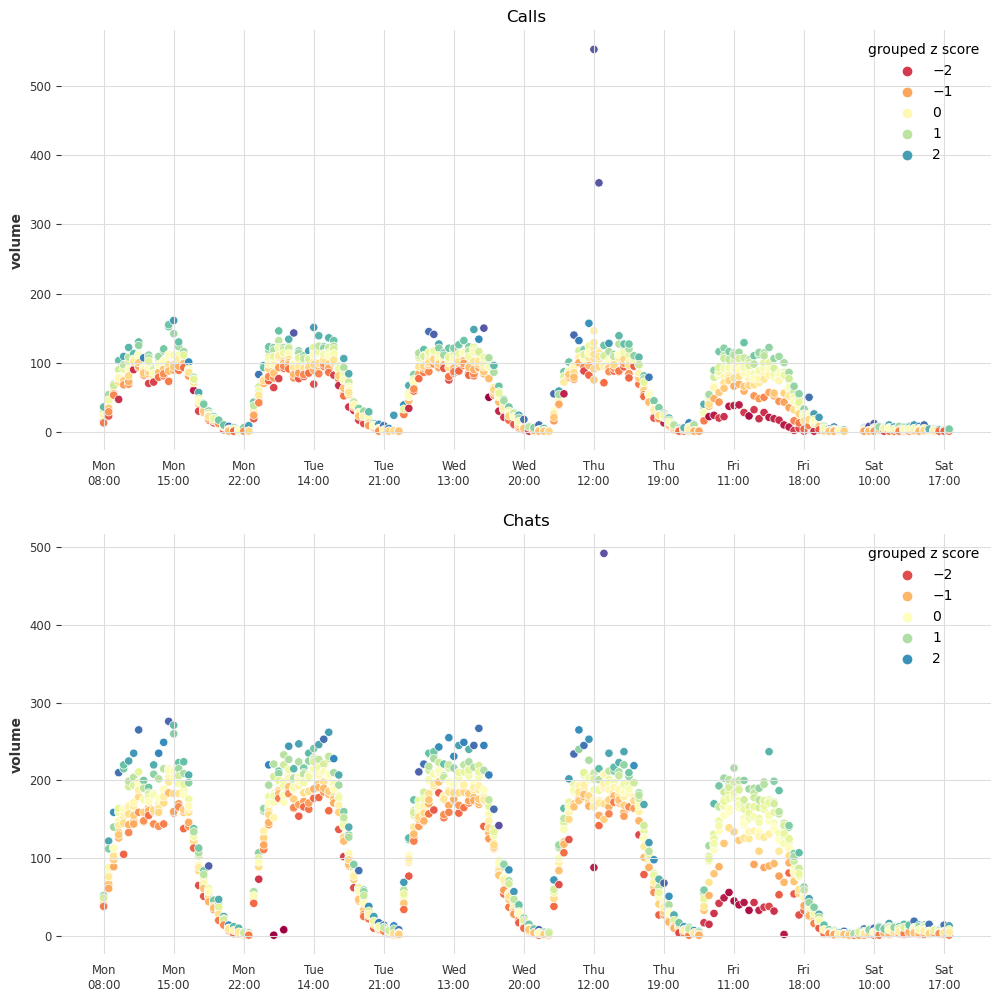

In [181]:
plot_z_scatter()

In [187]:
# function for picking/plotting z score thresholds
def plot_z_scatter2(dat = block_df, save =True):
    '''
    Scatter plot of volume by day/time with z score as hue param
    '''
    # process the data as a df
    t_df = dat.sort_values(['day_of_week','hour'])

    # create plotting vars
    t_df['x_var'] = t_df['dayname'].str[:3]+'\n'+t_df['hour']
    
   
    # plot the data
    fig,ax = plt.subplots(2,1, figsize=(12,12))

    #set color palette
    color_pal = 'Spectral'

    im1=ax[0].scatter(x='x_var'
                   ,y='volume'
                   ,c='grouped z score'
                   ,s=10
                   ,data=t_df[t_df['interaction_type']=='Call']
                    ,cmap=color_pal
                    )
    ax[0].set_title('Calls')
        
    im2=ax[1].scatter(x='x_var'
                   ,y='volume'
                   ,c='grouped z score'
                   ,s=10
                   ,data=t_df[t_df['interaction_type']=='Chat']
                    ,cmap=color_pal
                    )
    ax[1].set_title('Chats')
        
    fig.colorbar(im1, ax=ax[0]).set_label('Z-score')
    fig.colorbar(im2, ax=ax[1]).set_label('Z-score')

    
    # adjust x axis ticks
    skip = 14 # number of steps to skip in the axis ticks
    
    for axis in ax:
        # get tick params
        x_locs, x_labels = axis.get_xticks(), axis.get_xticklabels()
        
        #set tick params
        axis.set_xticks(x_locs[::skip])
        axis.set_xticklabels(x_labels[::skip])
        
        # clear the xlabel
        axis.set_xlabel(None)
    
    if save:
        plt.savefig('volume and z scores.png', bbox_inches='tight')
        
    plt.show()
    return None

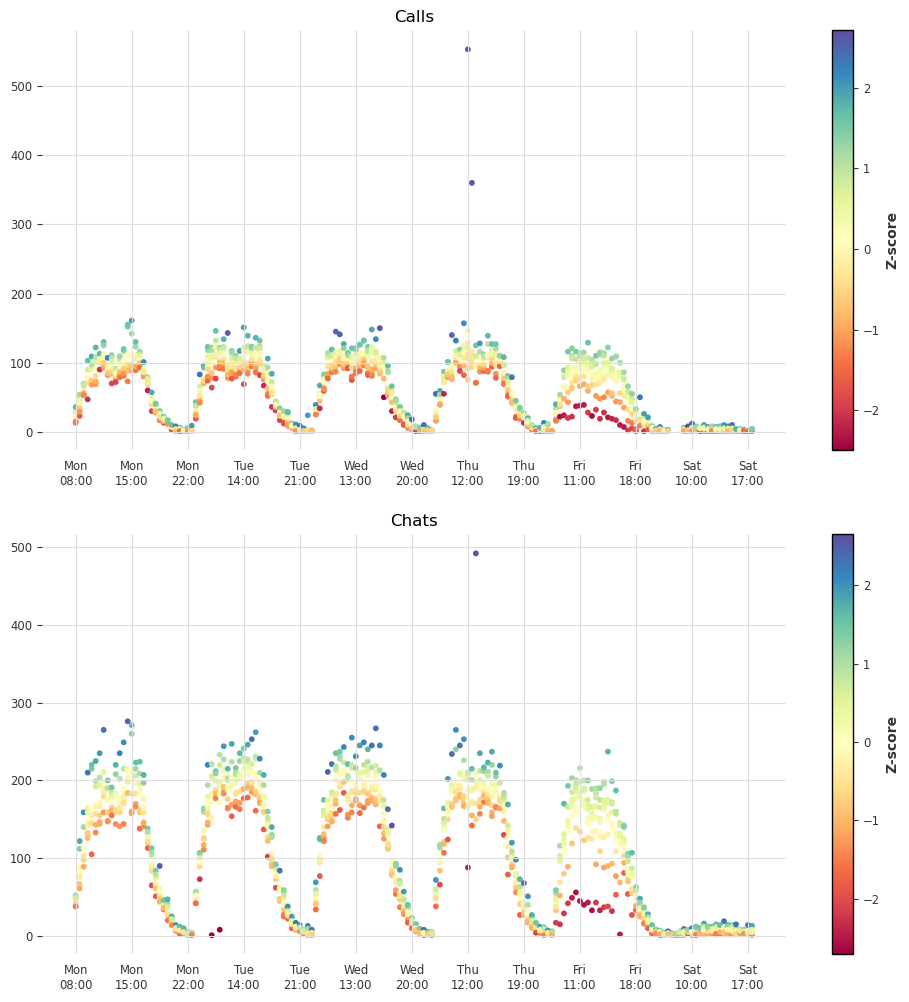

In [188]:
plot_z_scatter2(save=True)

### looking at quartiles

In [60]:
q=block_df[['interaction_type','volume']].groupby('interaction_type',as_index=False).quantile(0.99)
q.rename(columns={'volume':'99th pctile'},inplace=True)
q

,interaction_type,99th pctile
0,Call,141.07
1,Chat,245.68


In [61]:
outliers=block_df.merge(q,on='interaction_type')
outliers['ratio'] = outliers['volume']/outliers['99th pctile']
outliers[outliers['volume']>outliers['99th pctile']].sort_values('ratio',ascending =False)

,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname,hour,Call,Chat,volume_pct,grouped z score,99th pctile,ratio
879,2022-12-04,2022-12-08,2022-12-08 12:00:00,5,Call,553,False,True,Thursday,12:00,9917.0,17444.0,0.055763,2.620004,141.07,3.920040
880,2022-12-04,2022-12-08,2022-12-08 12:30:00,5,Call,360,False,True,Thursday,12:30,9917.0,17444.0,0.036301,2.634979,141.07,2.551925
2291,2022-12-04,2022-12-08,2022-12-08 13:00:00,5,Chat,492,False,True,Thursday,13:00,9917.0,17444.0,0.028205,2.610690,245.68,2.002605
177,2022-11-06,2022-11-07,2022-11-07 15:00:00,2,Call,161,False,True,Monday,15:00,9676.0,17466.0,0.016639,2.035585,141.07,1.141277
1407,2022-10-30,2022-10-31,2022-10-31 14:30:00,2,Chat,276,False,True,Monday,14:30,10871.0,21148.0,0.013051,2.429780,245.68,1.123413
1199,2022-12-18,2022-12-22,2022-12-22 11:30:00,5,Call,157,False,True,Thursday,11:30,8466.0,16209.0,0.018545,2.113689,141.07,1.112923
1408,2022-10-30,2022-10-31,2022-10-31 15:00:00,2,Chat,271,False,True,Monday,15:00,10871.0,21148.0,0.012814,1.632089,245.68,1.103061
176,2022-11-06,2022-11-07,2022-11-07 14:30:00,2,Call,155,False,True,Monday,14:30,9676.0,17466.0,0.016019,1.628649,141.07,1.098745
1469,2022-10-30,2022-11-02,2022-11-02 15:30:00,4,Chat,267,False,True,Wednesday,15:30,10871.0,21148.0,0.012625,2.319402,245.68,1.086780
1489,2022-10-30,2022-11-03,2022-11-03 10:30:00,5,Chat,265,False,True,Thursday,10:30,10871.0,21148.0,0.012531,2.048317,245.68,1.078639


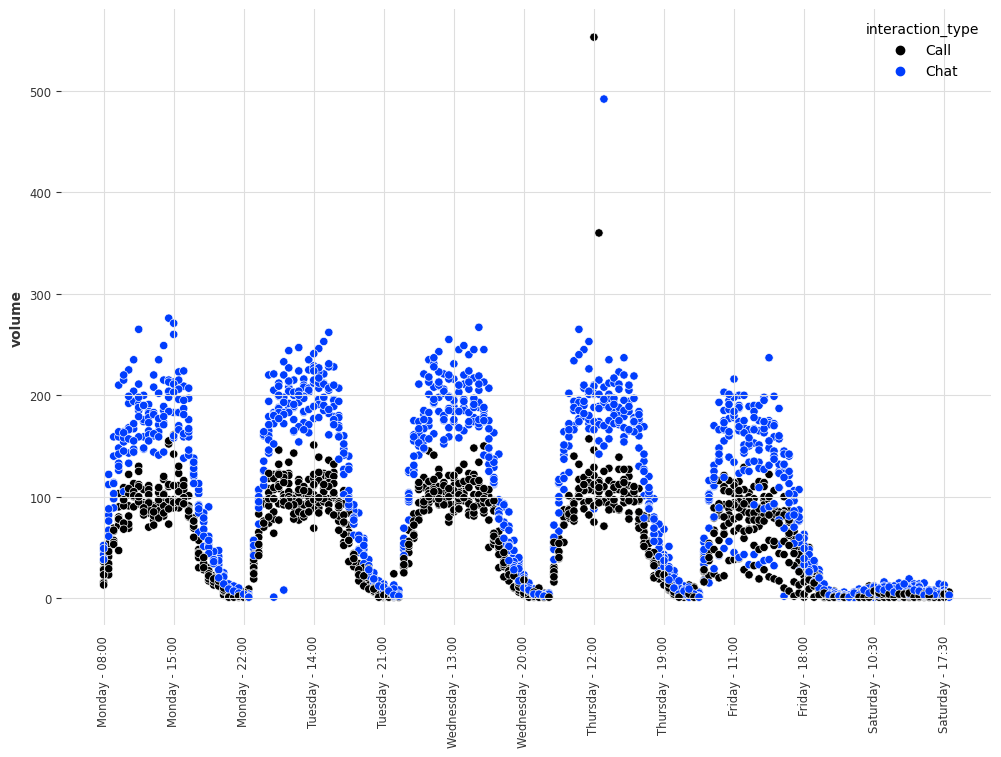

In [128]:
# scatter plot calls and chats to identify outliers
plt.figure(figsize=(12,8))

sns.scatterplot(x=block_df['dayname']+' - '+block_df['hour']
               ,y=block_df['volume']
               ,hue=block_df['interaction_type'])

# adjust x axis ticks
skip = 14 # number of steps to skip in the axis ticks
x_locs, x_labels = plt.xticks()
plt.xticks(x_locs[::skip], x_labels[::skip], rotation=90)
    
    
plt.xlabel(None)

plt.show()

In [63]:
# why does there appear to be a monday with no volume?
block_df[(block_df['volume']<10)&(block_df['dayname']=='Monday')].sort_values('bucket')

,weekstart,date,bucket,day_of_week,interaction_type,volume,is_holiday,is_workday,dayname,hour,Call,Chat,volume_pct,grouped z score
49,2022-10-30,2022-10-31,2022-10-31 20:00:00,2,Call,5,False,True,Monday,20:00,10871.0,21148.0,0.000460,-0.881917
50,2022-10-30,2022-10-31,2022-10-31 20:30:00,2,Call,1,False,True,Monday,20:30,10871.0,21148.0,0.000092,-0.787562
52,2022-10-30,2022-10-31,2022-10-31 21:00:00,2,Call,2,False,True,Monday,21:00,10871.0,21148.0,0.000184,-0.845154
54,2022-10-30,2022-10-31,2022-10-31 21:30:00,2,Chat,6,False,True,Monday,21:30,10871.0,21148.0,0.000284,0.000000
55,2022-10-30,2022-10-31,2022-10-31 21:30:00,2,Call,1,False,True,Monday,21:30,10871.0,21148.0,0.000092,-1.459601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,2022-12-18,2022-12-19,2022-12-19 21:30:00,2,Call,2,False,True,Monday,21:30,8466.0,16209.0,0.000236,0.208514
2302,2022-12-18,2022-12-19,2022-12-19 22:00:00,2,Call,1,False,True,Monday,22:00,8466.0,16209.0,0.000118,-1.171700
2303,2022-12-18,2022-12-19,2022-12-19 22:00:00,2,Chat,4,False,True,Monday,22:00,8466.0,16209.0,0.000247,0.732410
2304,2022-12-18,2022-12-19,2022-12-19 22:30:00,2,Call,1,False,True,Monday,22:30,8466.0,16209.0,0.000118,-0.500000


In [64]:
raw_df[raw_df['is_holiday']].value_counts('date').sort_index()

date
2020-01-20    30
2020-11-26    15
2020-11-27    45
2020-12-24    42
2020-12-25    10
2021-01-01    18
2021-01-18    57
2021-05-31    24
2021-07-05    26
2021-09-06    18
2021-11-25    10
2021-12-24    18
2021-12-31    25
2022-01-17    29
2022-05-30    22
2022-07-04     2
2022-09-05    13
2022-11-24     8
2022-12-26    25
dtype: int64